Silhouette Score: 0.1682338742465865


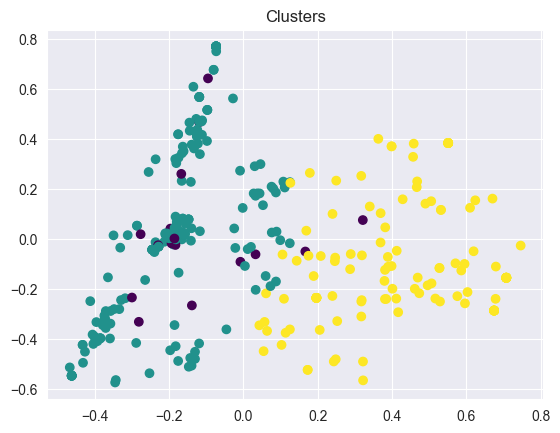

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.semi_supervised import LabelSpreading
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics import silhouette_score

# Load labeled and unlabeled data
labeled_data = pd.read_csv('../semi_supervised_data/labeled_data.csv')
unlabeled_data = pd.read_csv('../semi_supervised_data/unlabeled_data.csv')

# Feature Extraction
vectorizer = TfidfVectorizer()

# Fit and transform labeled data
X_labeled = vectorizer.fit_transform(labeled_data['comment'])

# Transform unlabeled data
X_unlabeled = vectorizer.transform(unlabeled_data['comment'])

# Encode labels
label_encoder = LabelEncoder()
y_labeled = label_encoder.fit_transform(labeled_data['stance'])

# Train classifier
classifier = MultinomialNB()
classifier.fit(X_labeled, y_labeled)

# Predict labels for unlabeled data
predicted_labels = classifier.predict(X_unlabeled)
predicted_labels = label_encoder.inverse_transform(predicted_labels)

# Combine features and labels
combined_features = np.vstack([X_unlabeled.toarray(), X_labeled.toarray()])
combined_labels = np.concatenate([predicted_labels, labeled_data['stance']])

# Perform clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Number of clusters = 3 (democrat, republican, other)
clusters = kmeans.fit_predict(combined_features)

# Evaluate clustering performance
silhouette_avg = silhouette_score(combined_features, clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Add cluster labels to the original unlabeled data
unlabeled_data['predicted_stance'] = predicted_labels
unlabeled_data['cluster'] = clusters[:len(unlabeled_data)]

# Perform PCA for visualization
pca = PCA(n_components=2)
pca.fit(combined_features)
reduced_features = pca.transform(combined_features)

# Plot the clusters
import matplotlib.pyplot as plt
    
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')
plt.title('Clusters')
plt.show()


In [24]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.sparse import hstack

# File path
file_path = '../semi_supervised_data/training_data.csv'

# Read the CSV file
data = pd.read_csv(file_path)

# Ensure correct columns are present
if not {'Tweet', 'Ideology'}.issubset(data.columns):
    raise ValueError("CSV file must contain 'Tweet' and 'Ideology' columns")

# Extract text features using TF-IDF
vectorizer = TfidfVectorizer()
text_features = vectorizer.fit_transform(data['Tweet'])

# Encode ideological stances
stance_encoder = LabelEncoder()
stance_features = stance_encoder.fit_transform(data['Ideology'])
stance_features = stance_features.reshape(-1, 1)  # Reshape to be a column vector

# Convert stance_features to a sparse matrix
from scipy.sparse import csr_matrix
stance_features_sparse = csr_matrix(stance_features)

# Combine text features with stance features
combined_features = hstack([text_features, stance_features_sparse])

# Apply KMeans clustering
num_clusters = 3  # You can change this based on your requirements
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(combined_features)

# Calculate Silhouette Score
score = silhouette_score(combined_features, clusters)
print(f"Silhouette Score: {score}")

# Display clustering results
data['Cluster'] = clusters
print(data.head())

# Optionally save results to a new CSV file
output_file_path = 'path_to_output_csv_file.csv'
data.to_csv(output_file_path, index=False)

Silhouette Score: 0.09632355777053203
                                               Tweet Ideology  Cluster
0  ['mayb', 'use', 'babysit', 'singl', 'parent', ...  Liberal        1
1  ['jare', 'kushner', 'id', 'resign', 'distract'...  Liberal        1
2  ['realdonaldtrump', 'good', 'news', 'hair', 's...  Liberal        1
3  ['would', 'happen', 'ivankatrump', 'vote', 'ma...  Liberal        1
4  ['new', 'hero', 'ye', 'newyorkstateag', 'go', ...  Liberal        1
